In [1]:
import pandas as pd

df = pd.read_csv('Small_Car_Data.csv')

In [2]:
df.head()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Acceleration,Cylinders,Displacement,Horsepower,Manufacturer,Model,Model_Year,MPG,Origin,Weight
0,12.0,8,307,130,chevrolet,chevrolet chevelle malibu,70,18.0,USA,3504
1,11.5,8,350,165,buick,buick skylark 320,70,15.0,USA,3693
2,11.0,8,318,150,plymouth,plymouth satellite,70,18.0,USA,3436
3,12.0,8,304,150,amc,amc rebel sst,70,16.0,USA,3433
4,10.5,8,302,140,ford,ford torino,70,17.0,USA,3449


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Acceleration  100 non-null    float64
 1   Cylinders     100 non-null    int64  
 2   Displacement  100 non-null    int64  
 3   Horsepower    100 non-null    int64  
 4   Manufacturer  100 non-null    object 
 5   Model         100 non-null    object 
 6   Model_Year    100 non-null    int64  
 7   MPG           100 non-null    float64
 8   Origin        100 non-null    object 
 9   Weight        100 non-null    int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 7.9+ KB


array([[<AxesSubplot: title={'center': 'Acceleration'}>,
        <AxesSubplot: title={'center': 'Cylinders'}>,
        <AxesSubplot: title={'center': 'Displacement'}>],
       [<AxesSubplot: title={'center': 'Horsepower'}>,
        <AxesSubplot: title={'center': 'Model_Year'}>,
        <AxesSubplot: title={'center': 'MPG'}>],
       [<AxesSubplot: title={'center': 'Weight'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

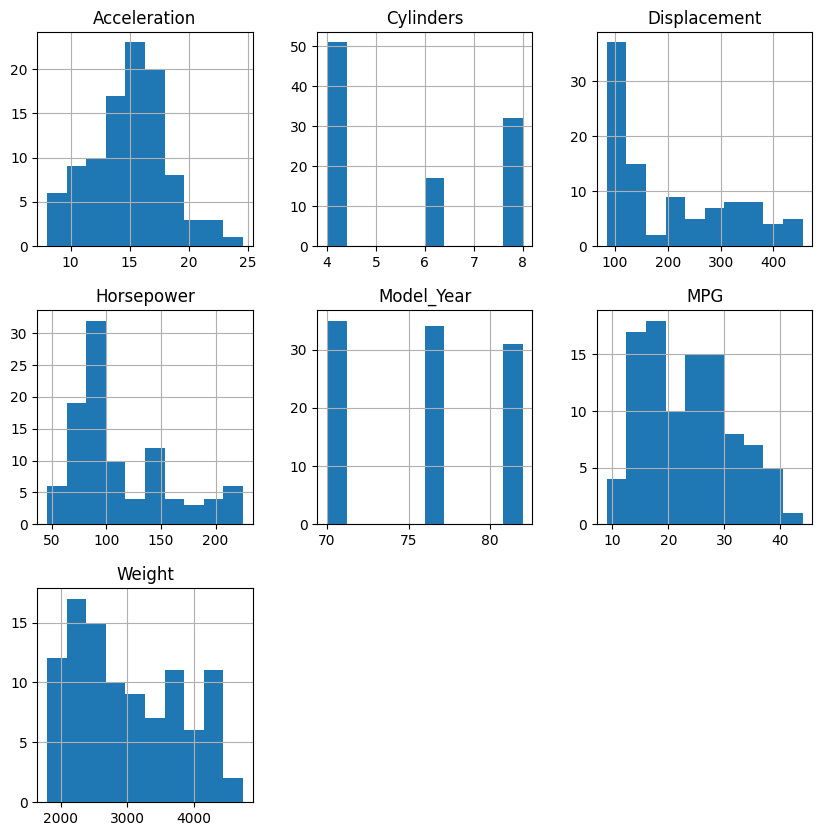

In [4]:
df.hist(figsize=(10, 10))

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

22/12/26 21:53:17 WARN Utils: Your hostname, Ajays-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.244 instead (on interface en0)
22/12/26 21:53:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/26 21:53:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
df = spark.createDataFrame(df)
df.show(5)

/Users/ajaydyavathi/miniforge3/envs/tf/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/ajaydyavathi/miniforge3/envs/tf/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+
|Acceleration|Cylinders|Displacement|Horsepower| Manufacturer|               Model|Model_Year| MPG| Origin|Weight|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+
|        12.0|        8|         307|       130|chevrolet    |chevrolet chevell...|        70|18.0|USA    |  3504|
|        11.5|        8|         350|       165|buick        |buick skylark 320...|        70|15.0|USA    |  3693|
|        11.0|        8|         318|       150|plymouth     |plymouth satellit...|        70|18.0|USA    |  3436|
|        12.0|        8|         304|       150|amc          |amc rebel sst    ...|        70|16.0|USA    |  3433|
|        10.5|        8|         302|       140|ford         |ford torino      ...|        70|17.0|USA    |  3449|
+------------+---------+------------+----------+-------------+------------------

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Horsepower"],
    outputCol="features"
)

df_vector = assembler.transform(df)

In [8]:
df_vector.show(3)

+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+--------+
|Acceleration|Cylinders|Displacement|Horsepower| Manufacturer|               Model|Model_Year| MPG| Origin|Weight|features|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+--------+
|        12.0|        8|         307|       130|chevrolet    |chevrolet chevell...|        70|18.0|USA    |  3504| [130.0]|
|        11.5|        8|         350|       165|buick        |buick skylark 320...|        70|15.0|USA    |  3693| [165.0]|
|        11.0|        8|         318|       150|plymouth     |plymouth satellit...|        70|18.0|USA    |  3436| [150.0]|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+--------+
only showing top 3 rows



In [9]:
df_final = df_vector.select(["features", "Displacement"])
df_final.show(2)

+--------+------------+
|features|Displacement|
+--------+------------+
| [130.0]|         307|
| [165.0]|         350|
+--------+------------+
only showing top 2 rows



In [10]:
df_train, df_test = df_final.randomSplit([0.9, 0.1])

In [11]:
df_train.count(), df_test.count()

(89, 11)

In [12]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="Displacement", maxIter=10, regParam=0.3)
lr_model = lr.fit(df_train)

22/12/26 21:53:26 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/12/26 21:53:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/26 21:53:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/12/26 21:53:26 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [13]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [2.226057281367776]
Intercept: -41.20196473329648


In [14]:
summary = lr_model.summary
print("RMSE:", round(summary.rootMeanSquaredError, 4))
print("r2:", round(summary.r2, 4))

RMSE: 46.7564
r2: 0.8168


In [15]:
lr_preds = lr_model.transform(df_test)
lr_preds.show(3)

+--------+------------+------------------+
|features|Displacement|        prediction|
+--------+------------+------------------+
| [150.0]|         304|   292.70662747187|
| [160.0]|         340|314.96720028554773|
| [170.0]|         383| 337.2277730992255|
+--------+------------+------------------+
only showing top 3 rows



In [16]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE evaluation
lr_eval = RegressionEvaluator(predictionCol="prediction", labelCol="Displacement")
lr_eval_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Displacement", metricName="r2")
print("RMSE (test data):", lr_eval.evaluate(lr_preds))
print("R2 (test data):", lr_eval_r2.evaluate(lr_preds))

RMSE (test data): 30.38683362100775
R2 (test data): 0.9418595538669011


Text(0, 0.5, 'Displacement')

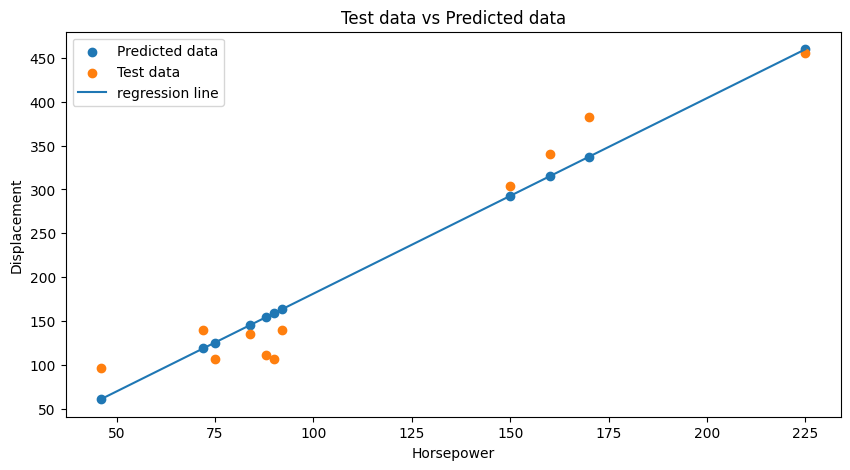

In [17]:
import matplotlib.pyplot as plt

pred_df = lr_preds.toPandas()
fts = [i[0] for i in pred_df['features']]
plt.figure(figsize=(10, 5))
plt.scatter(fts, pred_df['prediction'].values, label="Predicted data")
plt.scatter(fts, pred_df['Displacement'].values, label="Test data")
func = lambda x: lr_model.coefficients[0] * x + lr_model.intercept

plt.plot([min(fts), max(fts)], list(map(func, [min(fts), max(fts)])), label="regression line")
plt.legend()
plt.title("Test data vs Predicted data")
plt.xlabel("Horsepower")
plt.ylabel("Displacement")

### Model 2

In [18]:
df.columns

['Acceleration',
 'Cylinders',
 'Displacement',
 'Horsepower',
 'Manufacturer',
 'Model',
 'Model_Year',
 'MPG',
 'Origin',
 'Weight']

In [19]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCols=["Manufacturer", "Origin"], outputCols=["Manufacturer_idx", "Origin_idx"])
model = indexer.fit(df)

In [20]:
t_df = model.transform(df)

In [21]:
t_df.show(2)

+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------+----------+
|Acceleration|Cylinders|Displacement|Horsepower| Manufacturer|               Model|Model_Year| MPG| Origin|Weight|Manufacturer_idx|Origin_idx|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------+----------+
|        12.0|        8|         307|       130|chevrolet    |chevrolet chevell...|        70|18.0|USA    |  3504|             1.0|       0.0|
|        11.5|        8|         350|       165|buick        |buick skylark 320...|        70|15.0|USA    |  3693|             9.0|       0.0|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------+----------+
only showing top 2 rows



In [22]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder()
encoder.setInputCols(["Manufacturer_idx", "Origin_idx"])
encoder.setOutputCols(["Manufacturer_cat", "Origin_cat"])
model = encoder.fit(t_df)

In [23]:
cat_df = model.transform(t_df)

In [24]:
cat_df.show(2)

+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------+----------+----------------+-------------+
|Acceleration|Cylinders|Displacement|Horsepower| Manufacturer|               Model|Model_Year| MPG| Origin|Weight|Manufacturer_idx|Origin_idx|Manufacturer_cat|   Origin_cat|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------+----------+----------------+-------------+
|        12.0|        8|         307|       130|chevrolet    |chevrolet chevell...|        70|18.0|USA    |  3504|             1.0|       0.0|  (27,[1],[1.0])|(5,[0],[1.0])|
|        11.5|        8|         350|       165|buick        |buick skylark 320...|        70|15.0|USA    |  3693|             9.0|       0.0|  (27,[9],[1.0])|(5,[0],[1.0])|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------

In [25]:
df_new = cat_df.drop("Manufacturer", "Manufacturer_idx", "Origin", "Origin_idx", "Model", "MPG")
df_new.show(2)

+------------+---------+------------+----------+----------+------+----------------+-------------+
|Acceleration|Cylinders|Displacement|Horsepower|Model_Year|Weight|Manufacturer_cat|   Origin_cat|
+------------+---------+------------+----------+----------+------+----------------+-------------+
|        12.0|        8|         307|       130|        70|  3504|  (27,[1],[1.0])|(5,[0],[1.0])|
|        11.5|        8|         350|       165|        70|  3693|  (27,[9],[1.0])|(5,[0],[1.0])|
+------------+---------+------------+----------+----------+------+----------------+-------------+
only showing top 2 rows



In [26]:
assembler = VectorAssembler(
    inputCols=["Cylinders", "Displacement", "Manufacturer_cat", "Model_Year", "Origin_cat", "Weight"],
    outputCol="features"
)

df_features = assembler.transform(df_new)
df_features.show(2)

+------------+---------+------------+----------+----------+------+----------------+-------------+--------------------+
|Acceleration|Cylinders|Displacement|Horsepower|Model_Year|Weight|Manufacturer_cat|   Origin_cat|            features|
+------------+---------+------------+----------+----------+------+----------------+-------------+--------------------+
|        12.0|        8|         307|       130|        70|  3504|  (27,[1],[1.0])|(5,[0],[1.0])|(36,[0,1,3,29,30,...|
|        11.5|        8|         350|       165|        70|  3693|  (27,[9],[1.0])|(5,[0],[1.0])|(36,[0,1,11,29,30...|
+------------+---------+------------+----------+----------+------+----------------+-------------+--------------------+
only showing top 2 rows



In [27]:
df_acc = df_features.select(['features', 'Acceleration'])
df_acc.show(2)

+--------------------+------------+
|            features|Acceleration|
+--------------------+------------+
|(36,[0,1,3,29,30,...|        12.0|
|(36,[0,1,11,29,30...|        11.5|
+--------------------+------------+
only showing top 2 rows



In [28]:
df_train, df_test = df_acc.randomSplit([0.9, 0.1])

In [29]:
df_train.count(), df_test.count()

(95, 5)

In [30]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="Acceleration", maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(df_train)

In [31]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.1726052625745371,-0.013702200008057388,0.0,0.08433132928054932,0.09451885855389282,0.0,-0.6875136256472446,0.0,0.0,-0.1763147399555461,0.0,0.0,0.0,0.0,1.8411665239025485,0.0,-1.1097630654750505,0.0,0.0,0.0,0.0,3.3688344382672812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08344064354470153,0.0,-0.3753253416660544,0.0,0.0,0.0,0.0]
Intercept: 12.512746324710873


In [32]:
summary = lr_model.summary
print("RMSE:", round(summary.rootMeanSquaredError, 4))
print("r2:", round(summary.r2, 4))

RMSE: 2.1224
r2: 0.5807


In [33]:
lr_preds = lr_model.transform(df_test)
lr_preds.show(3)

+--------------------+------------+------------------+
|            features|Acceleration|        prediction|
+--------------------+------------+------------------+
|(36,[0,1,8,29,32,...|        20.5|16.334056921760265|
|(36,[0,1,12,29,31...|        14.5|15.958731580094211|
|(36,[0,1,6,29,30,...|        15.4| 14.04809503120081|
+--------------------+------------+------------------+
only showing top 3 rows



In [34]:
# RMSE evaluation
lr_eval = RegressionEvaluator(predictionCol="prediction", labelCol="Acceleration")
lr_eval_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Acceleration", metricName="r2")
print("RMSE (test data):", lr_eval.evaluate(lr_preds))
print("R2 (test data):", lr_eval_r2.evaluate(lr_preds))

RMSE (test data): 3.7356572451658763
R2 (test data): 0.00451299339722766


## Final Version

## Linear Regression

In [35]:
assembler = VectorAssembler(
    inputCols=["Cylinders", "Displacement", "Manufacturer_cat", "Model_Year", "Origin_cat", "Weight", "Acceleration", "Horsepower"],
    outputCol="features"
)

df_features = assembler.transform(cat_df)
df_features.show(2)

+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------+----------+----------------+-------------+--------------------+
|Acceleration|Cylinders|Displacement|Horsepower| Manufacturer|               Model|Model_Year| MPG| Origin|Weight|Manufacturer_idx|Origin_idx|Manufacturer_cat|   Origin_cat|            features|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+----------------+----------+----------------+-------------+--------------------+
|        12.0|        8|         307|       130|chevrolet    |chevrolet chevell...|        70|18.0|USA    |  3504|             1.0|       0.0|  (27,[1],[1.0])|(5,[0],[1.0])|(38,[0,1,3,29,30,...|
|        11.5|        8|         350|       165|buick        |buick skylark 320...|        70|15.0|USA    |  3693|             9.0|       0.0|  (27,[9],[1.0])|(5,[0],[1.0])|(38,[0,1,11,29,30...|
+------------+---------+-

In [36]:
df_final = df_features.select(['features', 'MPG'])
df_final.show(2)

+--------------------+----+
|            features| MPG|
+--------------------+----+
|(38,[0,1,3,29,30,...|18.0|
|(38,[0,1,11,29,30...|15.0|
+--------------------+----+
only showing top 2 rows



In [37]:
df_train, df_test = df_final.randomSplit([0.9, 0.1])

In [38]:
df_train.count(), df_test.count()

(89, 11)

In [39]:
lr = LinearRegression(featuresCol="features", labelCol="MPG", maxIter=10, regParam=0.3)
lr_model = lr.fit(df_train)

In [40]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-1.2417382140002136,-0.0016586034234000097,-1.145185956001521,0.22472898942582578,-0.6099194136506302,-0.4092794974766863,1.5293314668624969,-1.9842097351122223,2.7748510547863865,2.225803688779511,0.6054203400097946,-0.9780292654038669,3.380953270145106,1.4663000960333878,0.0093926137496054,-1.5807857909764746,-0.34782129148310564,1.0120771586302963,-3.489771756564823,-6.173907680790496,0.0,-1.0391780839256888,-3.781137412139316,0.0,3.417407549280013,12.401081943074393,-3.325905069977393,0.1700463698347177,4.833519570710729,0.4374351893737858,-0.16655830595842655,1.241190176415598,0.5143059462882679,-1.549133766387271,-4.513845451026045,-0.0030785788705236577,-0.24168169868092054,-0.014889459886502402]
Intercept: 11.974733551223686


In [41]:
summary = lr_model.summary
print("RMSE:", round(summary.rootMeanSquaredError, 4))
print("r2:", round(summary.r2, 4))

RMSE: 2.5405
r2: 0.8981


In [42]:
lr_preds = lr_model.transform(df_test)
lr_preds.show(3)

+--------------------+----+------------------+
|            features| MPG|        prediction|
+--------------------+----+------------------+
|(38,[0,1,6,29,30,...|18.0|18.026713700065073|
|(38,[0,1,4,29,30,...|18.0|20.307905997144125|
|(38,[0,1,5,29,30,...|15.0| 15.53320649759926|
+--------------------+----+------------------+
only showing top 3 rows



In [43]:
# RMSE evaluation
lr_eval = RegressionEvaluator(predictionCol="prediction", labelCol="MPG")
lr_eval_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="MPG", metricName="r2")
print("RMSE (test data):", lr_eval.evaluate(lr_preds))
print("R2 (test data):", lr_eval_r2.evaluate(lr_preds))

RMSE (test data): 2.8247939461006433
R2 (test data): 0.860766491976473


## Decision Tree Regressor

In [44]:
from pyspark.ml.regression import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(featuresCol="features", labelCol="MPG")
dt_model = dt_reg.fit(df_train)

In [45]:
dt_preds = dt_model.transform(df_test)
dt_preds.show(3)

+--------------------+----+----------+
|            features| MPG|prediction|
+--------------------+----+----------+
|(38,[0,1,6,29,30,...|18.0|      16.9|
|(38,[0,1,4,29,30,...|18.0|     20.75|
|(38,[0,1,5,29,30,...|15.0|      16.9|
+--------------------+----+----------+
only showing top 3 rows



In [46]:
# RMSE evaluation
dt_eval = RegressionEvaluator(predictionCol="prediction", labelCol="MPG")
dt_eval_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="MPG", metricName="r2")
print("RMSE (test data):", dt_eval.evaluate(dt_preds))
print("R2 (test data):", dt_eval_r2.evaluate(dt_preds))

RMSE (test data): 2.462501262233535
R2 (test data): 0.8941908705102442


22/12/27 03:47:57 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1046217 ms exceeds timeout 120000 ms
22/12/27 03:47:57 WARN SparkContext: Killing executors is not supported by current scheduler.
